In [1]:
from imp import reload
import sys, os
from copy import deepcopy
print('python version %s' % sys.version)

import numpy as np
print('numpy version %s' % np.__version__)

import scipy as sp
import scipy.stats as st
print('scipy version %s' % sp.__version__)

import pandas as pd
print('pandas version %s' % pd.__version__)

import matplotlib
from matplotlib import cm
import matplotlib.pyplot as plt
print('matplotlib version %s' % matplotlib.__version__)

python version 3.9.9 | packaged by conda-forge | (main, Dec 20 2021, 02:41:07) 
[Clang 11.1.0 ]
numpy version 1.20.3
scipy version 1.7.3
pandas version 1.3.5
matplotlib version 3.5.1


In [2]:
SIMULATION_DIRECTORY = 'simulations'
DATA_DIRECTORY       = os.getcwd()
SCRIPT_DIRECTORY     = ''
INFERENCE_DATE       = 'data'
SARS_DATA_DIR        = os.path.join(DATA_DIRECTORY, INFERENCE_DATE)

import epi_figs as ef

# Figures for paper

In [3]:
# Figure 1 -- inference results for simulations

import figs as f
reload(f)

data = { 'sim_file':       os.path.join(SIMULATION_DIRECTORY, 'sim-init-sample50-T50.npz'),
         'inf_file':       os.path.join(SIMULATION_DIRECTORY, 'inf-init-sample50-T50.npz'),
         'replicate_file': os.path.join(SIMULATION_DIRECTORY, 'epi-init-sample50-T50.npz'),
         'pop_size':       10000,
         'cutoff':         0.01 }

f.plot_performance(**data)

In [4]:
# Figure 2 -- aggregate statistics for inferred coefficients

import figs as f
reload(f)
        
data = { 'selection_file_all': os.path.join(SARS_DATA_DIR, 'selection-g40-1pct-nonsyn-paper.csv'),
         'selection_file_ns':  os.path.join(SARS_DATA_DIR, 'selection-g40-1pct-nonsyn-collapsed-paper.csv'),
         'label2ddr':          { 'NSP1':  0.01,
                                 'NSP2':  0.02,
                                 'NSP7':  0.09,
                                 'NSP13': 0.03,
                                 'E':     0.09,
                                 'ORF6':  0.12,
                                 'ORF7a': 0.09,
                                 'ORF7b': 0.08,
                                 'ORF8':  0.03,
                                 'ORF10': 0.01 } }

f.plot_selection_statistics_extended(**data)

In [5]:
# Selection coefficients and ranks for specific mutations

df = pd.read_csv(os.path.join(SARS_DATA_DIR, 'selection-g40-1pct-nonsyn-paper.csv'), memory_map=True)

print('We estimate selection coefficients for %d nonsynonymous single nucleotide variants\n' % len(df))


df = pd.read_csv(os.path.join(SARS_DATA_DIR, 'selection-g40-1pct-nonsyn-collapsed-paper.csv'), memory_map=True)

names = ['NSP6:d106', 'NSP6:d107', 'NSP6:d108', 'S:E484K ', 'S:S477N ', 'S:N501Y ', 'S:D614G ', 'N:R203M ']
idxs  = [      11288,       11291,       11294,      23012,      22992,      23063,      23403,      28881]
nucs  = [        '-',         '-',         '-',        'A',        'A',        'T',        'G',        'T']

names = names + ['N:T205I ', 'N:S202N ', 'N:S202R ', 'ORF7a:T120I', 'M:I82T  ', 'S:A222V ']
idxs  = idxs  + [     28887,      28878,      28879,         27752,      26767,      22227]
nucs  = nucs  + [       'T',        'A',        'A',           'T',        'C',        'T']

print('name\t\ts\trank')
for i in range(len(names)):
    df_temp = df[(df['nucleotide number']==idxs[i]) & (df['nucleotide']==nucs[i])]
    print('%s\t%.3f\t%d' % (names[i], df_temp.iloc[0]['selection coefficient'], 
                            1 + np.sum(df['selection coefficient']>df_temp.iloc[0]['selection coefficient'])))

We estimate selection coefficients for 13184 nonsynonymous single nucleotide variants

name		s	rank
NSP6:d106	0.054	7
NSP6:d107	0.042	23
NSP6:d108	0.031	43
S:E484K 	0.052	9
S:S477N 	0.044	15
S:N501Y 	0.029	58
S:D614G 	0.029	52
N:R203M 	0.046	13
N:T205I 	0.033	40
N:S202N 	0.033	39
N:S202R 	0.017	163
ORF7a:T120I	0.044	16
M:I82T  	0.075	2
S:A222V 	0.038	29


In [6]:
# Figure 3 -- selection and trajectories for variants

import figs as f
reload(f)

data = { 'variant_file':    os.path.join(SARS_DATA_DIR, 'linked-coefficients-g-40-1pct.csv'),
         'trajectory_file': os.path.join(SARS_DATA_DIR, 'linked-trajectories-1pct.csv'),
         'variant_list':    ['alpha', 'beta', 'gamma', 'delta', 'lambda', 'epsilon', 'B.1'],
         'variant_names':   ['Alpha', 'Beta', 'Gamma', 'Delta', 'Lambda', 'Epsilon', 'D614G cluster'],
         's_cutoff':        0.05 }

f.plot_variant_selection(**data)

variant	w
delta	0.842
gamma	0.566
alpha	0.517
beta	0.448
lambda	0.399
epsilon	0.252
B.1	0.090


In [7]:
# Figure 4 -- A222V trajectories and selection

import figs as f
reload(f)

data = { 'trajectory_file': os.path.join(SARS_DATA_DIR, 'linked-trajectories-1pct.csv'),
         'alpha_file':      os.path.join(SARS_DATA_DIR, 'alpha-uk.csv'),
         'eu1_file':        os.path.join(SARS_DATA_DIR, '20e-eu1-uk.csv'),
         'variant_id':      '20E_EU1',
         'selection_file':  os.path.join(SARS_DATA_DIR, 'S-A222V-tv-s.csv') }

f.plot_a222v(**data)

In [8]:
# Figure 5 -- early detection

import figs as f
reload(f)

data = { 'null_file':   os.path.join(SARS_DATA_DIR, 'null-distribution.dat'),
         'alpha_file':  os.path.join(SARS_DATA_DIR, 'alpha-tv-s.csv'),
         'alpha_start': 309,
         'alpha_end':   309+57,
         'delta_file':  os.path.join(SARS_DATA_DIR, 'delta-tv-s.csv'),
         'delta_start': 450,
         'delta_end':   450+57 }

f.plot_early_detection(**data)

hard w cutoff = 0.0406
soft w cutoff = 0.0046

time
cutoff	alpha	delta
hard	314	456
soft	314	450

frequency
cutoff	alpha	delta
hard	0.011	0.001
soft	0.011	0.000

First observed at 309, detected selection at 314

First observed at 450, detected selection at 456



/Users/jpbarton/Dropbox/git/paper-SARS-CoV-2-transmission/mplot.py:1016: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  if 'ylim' in pdata: pdata['ax'].set_ylim(pdata['ylim'][0], pdata['ylim'][1])


# Accessory code

In [9]:
# Processing data for trajectory files

df_traj = pd.read_csv(os.path.join(SARS_DATA_DIR, 'linked-trajectories-1pct.csv'), memory_map=True)

df_temp = df_traj[(df_traj.variant_names=='alpha') & (df_traj.location.str.contains('england'))]
times = np.array([])
freqs = np.array([])
for k in range(len(df_temp)):
    entry = df_temp.iloc[k]
    times = np.concatenate((times, np.array(entry.times.split(), float)), axis=None)
    freqs = np.concatenate((freqs, np.array(entry.frequencies.split(), float)), axis=None)

time_order = np.argsort(times)
times = times[time_order]
freqs = freqs[time_order]

full_times = np.arange(times[0], times[-1], 1)
full_freqs = np.zeros(len(full_times))
idx = 0
for i in range(len(full_times)):
    t = full_times[i]
    if t in times:
        idx = times.tolist().index(t)
        full_freqs[i] = freqs[idx]
    else:
        f0 = freqs[idx]
        f1 = freqs[idx+1]
        t0 = times[idx]
        t1 = times[idx+1]
        x  = (t - t0) / (t1 - t0)
        full_freqs[i] = (1 - x)*f0 + x*f1

f = open('alpha-uk.csv', 'w')
f.write('time,frequency\n')
for i in range(len(full_times)):
    f.write('%d,%.8e\n' % (full_times[i], full_freqs[i]))
f.close()

In [10]:
df_traj = pd.read_csv(os.path.join(SARS_DATA_DIR, '20E-EU1-trajectory.csv'), memory_map=True)

times = np.array(df_traj.time)
freqs = np.array(df_traj.frequency)

time_order = np.argsort(times)
times = times[time_order]
freqs = freqs[time_order]

full_times = np.arange(times[0], times[-1], 1)
full_freqs = np.zeros(len(full_times))
idx = 0
for i in range(len(full_times)):
    t = full_times[i]
    if t in times:
        idx = times.tolist().index(t)
        full_freqs[i] = freqs[idx]
    else:
        f0 = freqs[idx]
        f1 = freqs[idx+1]
        t0 = times[idx]
        t1 = times[idx+1]
        x  = (t - t0) / (t1 - t0)
        full_freqs[i] = (1 - x)*f0 + x*f1

f = open('20e-eu1-uk.csv', 'w')
f.write('time,frequency\n')
for i in range(len(full_times)):
    f.write('%d,%.8e\n' % (full_times[i], full_freqs[i]))
f.close()

# Supplementary Figures

In [11]:
import epi_figs as ef

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in a

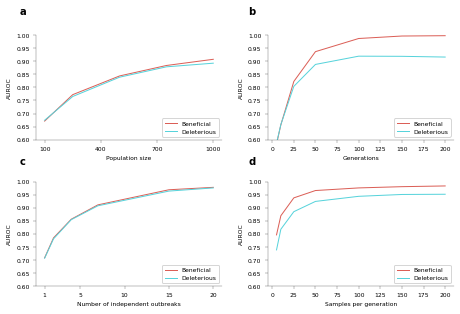

In [12]:
# Supplementary Figure 1 -- AUROC plots for various parameters 

reload(ef)
ef.auroc_plots_combined(os.path.join(SIMULATION_DIRECTORY, 'epi-init-sim'), 
                        os.path.join(SIMULATION_DIRECTORY, 'epi-init-T'), 
                        os.path.join(SIMULATION_DIRECTORY, 'epi-init-sample'), 
                        os.path.join(SIMULATION_DIRECTORY, 'epi-init-smallpop'))

In [13]:
# Supplementary Figure 2 -- SIR

In [14]:
# Supplementary Figure 3 -- SIR

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


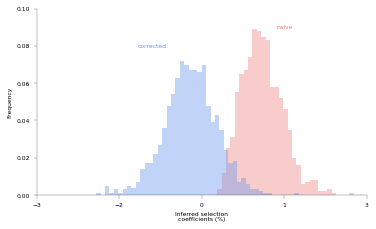

In [15]:
# Supplementary Figure 4 -- correction to selection due to travel

ef.hist_plot_inflow(os.path.join(SIMULATION_DIRECTORY, 'epi-init-in1.npz'), 
                    os.path.join(SIMULATION_DIRECTORY, 'epi-init-in1-corrected.npz'), 1)

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
/Users/jpbarton/Dropbox/git/paper-SARS-CoV-2-transmission/epi_figs.py:546: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  all_times = np.array(all_times)[sorter]


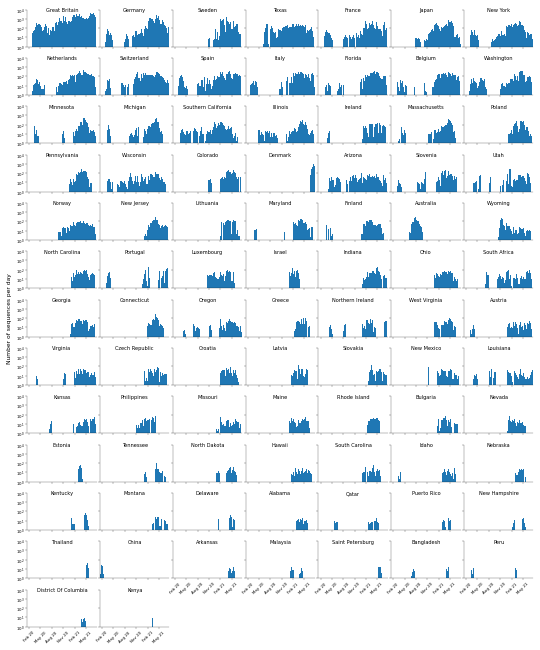

In [16]:
# Supplementary Figure 5 -- sampling distributions in different regions

sampling_dir = os.path.join(SARS_DATA_DIR, 'sampling-data')
#os.remove(os.path.join(sampling_dir, '.DS_store'))
ef.sampling_plots(sampling_dir, log=True)

In [17]:
# Supplementary Figure 4 -- enrichment of nonsynonymous mutations among mutations with large selection coefficients

#ef.syn_percentage_plots('infer-2021-08-14-g-40-1pct-observed.npz', 
#                        'linked-sites-1pct-regional.npy', 
#                        'synonymous.npz',
#                         out_file = 'syn_dist_plot_regional')

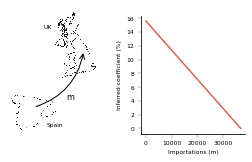

In [18]:
# Supplementary Figure 6 -- effect of travel on inferred coefficients for the 20E(EU1) variant in the United Kingdom

inflow_dir = os.path.join(SARS_DATA_DIR, 'inflow-uk')
ef.migration_plot(inflow_dir, os.path.join(SARS_DATA_DIR,'20E-EU1.npy'))

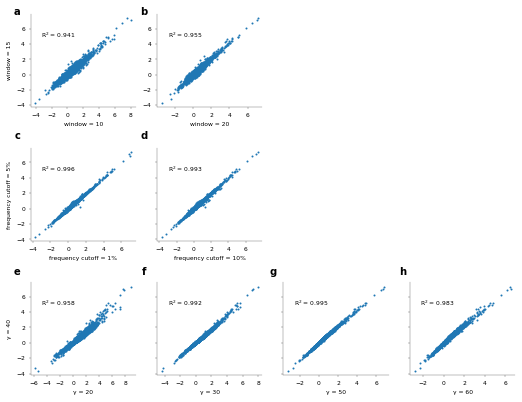

In [19]:
# Supplementary Figure 7 -- checks for how inferred coefficients change as various model or data analysis 
# parameters are changed
inf_dir = os.path.join(SARS_DATA_DIR, 'sensitivity-data')
if not os.path.exists(inf_dir):
    os.mkdir(inf_dir)
file1   = os.path.join(inf_dir, 'infer-2021-08-14-g-40-observed.npz')
file2   = os.path.join(inf_dir, 'infer-2021-08-14-g-20-observed.npz')
file3   = os.path.join(inf_dir, 'infer-2021-08-14-g-30-observed.npz')
file4   = os.path.join(inf_dir, 'infer-2021-08-14-g-50-observed.npz')
file5   = os.path.join(inf_dir, 'infer-2021-08-14-g-60-observed.npz')
files   = [file1, file2, file3, file4, file5]
labels  = ['\u03B3 = 40', '\u03B3 = 20', '\u03B3 = 30', '\u03B3 = 50', '\u03B3 = 60']

file_cut1 = os.path.join(inf_dir, 'infer-2021-08-14-g-40-observed.npz')
file_cut2 = os.path.join(inf_dir, 'infer-2021-08-14-g-40-1pct-observed.npz')
file_cut3 = os.path.join(inf_dir, 'infer-2021-08-14-g-40-10pct-observed.npz')
files_cut = [file_cut1, file_cut2, file_cut3]
label_cut = ['frequency cutoff = 5%', 'frequency cutoff = 1%', 'frequency cutoff = 10%']

file_wind1 = os.path.join(inf_dir, 'infer-2021-08-14-cutoff0.1.npz')
file_wind2 = os.path.join(inf_dir, 'infer-2021-08-14-cutoff0.1-window10.npz')
file_wind3 = os.path.join(inf_dir, 'infer-2021-08-14-cutoff0.1-window20.npz')
files_wind = [file_wind1, file_wind2, file_wind3]
label_wind = ['window = 15', 'window = 10', 'window = 20']

reload(ef)
ef.s_compare_regs_cutoff_window(files_reg=files, labels_reg=labels, 
                                files_cutoff=files_cut, labels_cutoff=label_cut, 
                                files_wind=files_wind, labels_wind=label_wind,
                                out='sensitivity-plots')

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in a

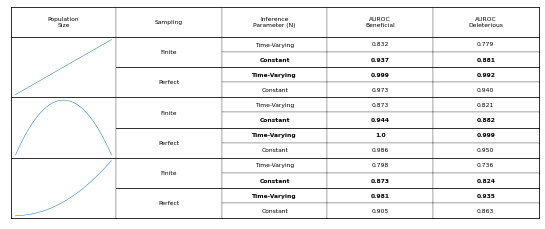

In [20]:
# Supplementary Figure 8 -- finite sampling and time-varying versus constant parameters

rep_finite_dir = os.path.join(SIMULATION_DIRECTORY, 'replicates-finite')
rep_perfect_dir = os.path.join(SIMULATION_DIRECTORY, 'replicates-perfect')
ef.finite_sampling_plot(rep_finite_dir, rep_perfect_dir)

In [21]:
# Table 1 -- selection coefficients for mutations

ef.selection_table(os.path.join(SARS_DATA_DIR, 'selection-g40-1pct-nonsyn-collapsed-paper.csv'))

\setlength{\tabcolsep}{12pt}
\begin{table}
\centering
\begin{tabular}{lllllll}
\toprule
 Rank   & Protein   & Mutation (nt)   & Mutation (aa)   & Selection (\%)   & Location   & Phenotypic effect   \\
\midrule
 1      & S         & T22918G         & L452R           & 7.5             &            &                     \\
 2      & M         & T26768C         & I82T            & 7.5             &            &                     \\
 3      & S         & C23605G         & P681R           & 7.2             &            &                     \\
 4      & S         & C23605A         & P681H           & 6.5             &            &                     \\
 5      & N         & G28281C         & D3L             & 6               &            &                     \\
 6      & NSP13     & C16467T         & P77L            & 5.5             &            &                     \\
 7      & NSP6      & T11289-         & S106-           & 5.4             &            &                     \\
 8    

In [22]:
# Table 2 -- selection coefficients for major variants of concern

ef.variant_selection_table(os.path.join(SARS_DATA_DIR, 'linked-coefficients-g-40-1pct.csv'), 
                           os.path.join(SARS_DATA_DIR, f'infer-2021-08-14-g-40-1pct-observed.npz'))

\setlength{\tabcolsep}{12pt}
\begin{table}
\centering
\begin{tabular}{llll}
\toprule
 Variant   & Pango Lineage    & Selection Coefficient (\%)   & Mutations                                                                                                                                                                                                                                                         \\
\midrule
 B.1       & B.1              & 9                           & S-D614G, NSP12-P323L                                                                                                                                                                                                                                              \\
 20E-EU1   & B.1.177          & 19.3                        & S-A222V, S-D614G, NSP12-P323L, N-A220V, ORF10-V30L                                                                                                                                                   